## Predict if a driver will file an insurance claim next year.

### Problem Statment: 
<ul>predict the probability that an auto insurance policy holder files a claim.<ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 65000)

from scipy import stats

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

##Synthetic Minority Over-sampling Technique to overcome imbalanced dataset
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, make_scorer
score_fun = make_scorer('roc_auc')

In [2]:
df = pd.read_csv("TRAIN.csv")

In [3]:
df['target'].value_counts(normalize=True)

0    0.963486
1    0.036514
Name: target, dtype: float64

In [4]:
df['target'].value_counts()

0    480895
1     18225
Name: target, dtype: int64

In [5]:
df_id = df['id']
y = df['target']
df.drop(columns=['id', 'target'], inplace=True)

In [6]:
df.shape

(499120, 57)

In [7]:
columns = df.columns.to_list()

In [8]:
cat = []
reg = []
for i in columns:
    if 'cat' in i:
        cat.append(i)
    elif 'bin' in i:
        cat.append(i)        
    elif 'reg' in i:
        reg.append(i)
    elif 'ind' in i:
        cat.append(i)
    elif df[i].dtype=='float64':
        reg.append(i)
    else:
        cat.append(i)

In [9]:
df[reg].head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2
1,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3
2,0.0,0.0,-1.000000,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1
3,0.9,0.2,0.580948,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1
4,0.7,0.6,0.840759,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0


In [10]:
df[reg] = df[reg].astype('float64')
df[cat] = df[cat].astype('O')

In [11]:
df[cat].describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120,499120
unique,8,5,12,3,8,2,2,2,2,2,2,2,2,5,14,2,2,2,13,3,3,10,3,18,3,2,6,3,104,5,6,7,11,10,11,8,26,19,11,14,24,2,2,2,2,2,2
top,0,1,2,0,0,0,0,0,0,0,0,0,0,0,7,1,0,0,11,1,-1,0,-1,11,1,1,2,1,104,3,2,2,8,3,9,2,8,5,1,2,7,0,1,1,0,0,0
freq,157091,361934,80545,290735,442648,302625,370927,417321,406487,498937,498280,494400,498657,493770,54797,330006,438623,422624,173931,414249,345221,416525,223678,110352,463814,415347,296380,494879,71138,267437,162831,163652,146665,136352,127277,153185,68798,85914,170372,116790,72819,437850,313346,276760,355759,324886,422517


In [12]:
rows, columns = df.shape
drop_nunique_col = []
for col in df.columns:
    if df[col].nunique == rows or df[col].nunique == 1:
        drop_nunique_col.append(col)
drop_nunique_col    

[]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.85, random_state=0)

In [14]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
        X_test[col] = X_test[col].fillna(X_train[col].mode()[0])
    else:
        X_train[col] = X_train[col].fillna(X_train[col].mean())
        X_test[col] = X_test[col].fillna(X_train[col].mean())

In [15]:

print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_train.shape)

# sampling_strategy=0.3, k_neighbors=8
smort = SMOTE()  ## SMOTE Parameters
X_train, y_train = smort.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_train.shape)


0    72153
1     2715
Name: target, dtype: int64
0    0.963736
1    0.036264
Name: target, dtype: float64
(74868,)
0    72153
1    72153
Name: target, dtype: int64
0    0.5
1    0.5
Name: target, dtype: float64
(144306,)


### Data Preprocessing -Lable Encoding, MinMax Scaling, Chi2Test

In [16]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [17]:
Le = LabelEncoderExt()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        Le.fit(X_train[col])
        X_train[col] = Le.transform(X_train[col]).asdtype('int64')
        X_test[col] = Le.transform(X_test[col]).asdtype('int64')

In [18]:
mMs = MinMaxScaler()
for col in reg:
        #mMs.fit([X_train[col]])
        X_train[col] = mMs.fit_transform(np.array(X_train[col]).reshape(-1, 1))
        X_test[col] = mMs.transform(np.array(X_test[col]).reshape(-1, 1))

## Checking Feature Importance

In [19]:
def featureIMP(model, X):
    
    fimpdf = pd.DataFrame(columns=['cName', 'f_imp'])
    fimpdf['f_imp'] = model.feature_importances_
    fimpdf['cName'] = X.columns
    
    fimpdf = fimpdf.sort_values('f_imp', ascending=False)
    
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(1, fimpdf.shape[0]+1), np.cumsum(fimpdf['f_imp']))
    plt.xlabel('No of Input Features in Train Data')
    plt.ylabel('Cumulative Sum of FeatureImportance')
    plt.title('Feature Importance Plot')
    
    fimpdf.reset_index(drop=True, inplace=True)

    return fimpdf

In [20]:
#feature_df = featureIMP(rf, X_train)

In [21]:
#final_col = feature_df[:20]['cName'].tolist()

## HyperParameter Tuning

In [22]:
rf_hyp = RandomForestClassifier(n_jobs=-1)

In [23]:
rf_params = {
    'n_estimators': np.arange(10,100,10),
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : np.arange(2,12,1), 
    'max_leaf_nodes': np.arange(2,12,1),
    'min_samples_leaf': np.arange(2,12,1)
}

In [24]:
rsCV = RandomizedSearchCV(estimator=rf_hyp, param_distributions=rf_params, n_iter=55, scoring='roc_auc')

In [25]:
rsCV.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_iter=55,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='roc_auc')

In [26]:
best_params = rsCV.best_params_

In [27]:
best_params

{'n_estimators': 70,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 11,
 'max_depth': 8,
 'criterion': 'entropy'}

In [28]:
rf_best_Model = rsCV.best_estimator_ ## Choosing Best estimator with best parameters

In [29]:
rf_best_Model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=11,
                       min_samples_leaf=3, n_estimators=70, n_jobs=-1)

In [30]:
def cross_val_model(X, y, model, n_splits=3, n_folds=3):
    'Do split dataset and calculate cross_score'
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s Split %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=n_folds, scoring='roc_auc')
        print("         Mean cross_score of %d Folds : =========:> %f" % (n_folds, cross_score.mean()))

In [31]:
cross_val_model(X_train, y_train, rf_best_Model, n_splits=5, n_folds=5)

Fit RandomForestClassifier Split 1
         Mean cross_score of 5 Folds : =========:> 0.941647
Fit RandomForestClassifier Split 2
         Mean cross_score of 5 Folds : =========:> 0.938074
Fit RandomForestClassifier Split 3
         Mean cross_score of 5 Folds : =========:> 0.945896
Fit RandomForestClassifier Split 4
         Mean cross_score of 5 Folds : =========:> 0.943000
Fit RandomForestClassifier Split 5
         Mean cross_score of 5 Folds : =========:> 0.939774


In [32]:
y_predict = rf_best_Model.predict(X_test)
y_predict_proba = rf_best_Model.predict_proba(X_test)[::,1]

In [33]:
train_acc = rf_best_Model.score(X_train, y_train)
test_acc =  rf_best_Model.score(X_test, y_test)

recallScore = recall_score(y_test, y_predict)
precisionScore = precision_score(y_test, y_predict)

f1Score = f1_score(y_test, y_predict)
auc = roc_auc_score(y_test, y_predict_proba)
fpr, tpr, thrshould = roc_curve(y_test, y_predict_proba)

In [34]:
print("Model Name: ", str(rf_best_Model).split("(")[0])
print("ConfusionMatrix: \n", confusion_matrix(y_test, y_predict))    
print("TrainAcc: ====> {}".format(train_acc))
print("TestAccuracy : ====> {}".format(test_acc))
print("recall: ====> {}".format(recallScore))
print("Precision: ====> {}".format(precisionScore))
print("F1Score: ====> {}".format(f1Score))
print("AUC: ====> {}".format(auc))

Model Name:  RandomForestClassifier
ConfusionMatrix: 
 [[374850  33892]
 [ 13665   1845]]
TrainAcc: ====> 0.876817318753205
TestAccuracy : ====> 0.8879038873122578
recall: ====> 0.11895551257253385
Precision: ====> 0.05162716512298178
F1Score: ====> 0.07200421488087108
AUC: ====> 0.5571842900489115


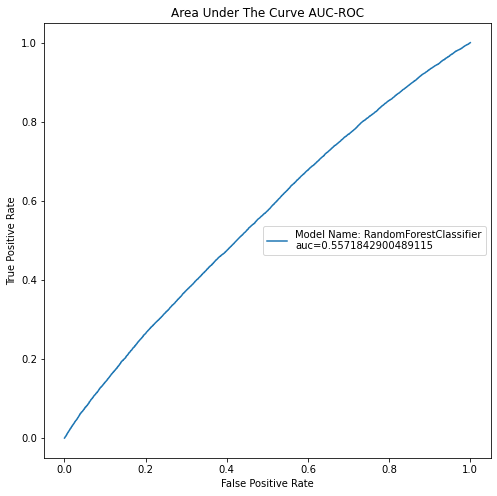

In [35]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label="Model Name: "+str(rf_best_Model).split("(")[0]+"\n"+"auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under The Curve AUC-ROC')

plt.legend(loc= 7)
plt.show()